# Linear SVM (Train on 2 Features, Plot in 2D)

In [59]:
# ==========================================
# Linear SVM from Scratch (Banknote Dataset)
# Allowed Libraries: NumPy, Pandas, Matplotlib
# ==========================================

# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
# Step 2: Load Dataset and Select Features
csv_path = "/kaggle/input/banknote-authenticationcsv/BankNote_Authentication.csv"
df = pd.read_csv(csv_path)

# Select two features for 2D visualization
feature_cols = ['variance', 'skewness']
label_col = 'class'

X = df[feature_cols].values.astype(np.float64)
y = df[label_col].values.astype(np.int64)

# Convert labels {0,1} → {-1,+1}
y = np.where(y == 0, -1, 1)

In [61]:
# Step 3: Standardize Features (mean=0, std=1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
X_scaled = (X - X_mean) / X_std

In [62]:
# Step 4: Split Data into Training and Test Sets
split_ratio = 0.8
split_index = int(split_ratio * len(X_scaled))

X_train = X_scaled[:split_index]
y_train = y[:split_index]

X_test = X_scaled[split_index:]
y_test = y[split_index:]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 1097, Test samples: 275


In [63]:
# Step 5: Define Hyperparameters
learning_rate = 0.001
lambda_reg = 0.01
num_iters = 3000
print_every = 300

# Step 6: Define Cost (Hinge Loss) Function
def hinge_loss_and_cost(w, b, X, y, lambda_reg):
    """
    Cost function:
    J(w,b) = λ/2 * ||w||^2 + (1/n) * Σ max(0, 1 - y*(Xw + b))
    """
    n = X.shape[0]
    scores = X.dot(w) + b
    margins = 1 - y * scores
    hinge_losses = np.maximum(0, margins)
    cost = 0.5 * lambda_reg * np.dot(w, w) + np.mean(hinge_losses)
    return cost, hinge_losses

In [64]:
# Step 7: Define Gradient Computation
def compute_gradients(w, b, X, y, lambda_reg):
    """
    Gradients based on margin violations:
    grad_w = λ*w - (1/n)*Σ(y_i * x_i) for y_i*(w·x_i + b) < 1
    grad_b = -(1/n)*Σ(y_i) for those violating margins
    """
    n = X.shape[0]
    scores = X.dot(w) + b
    mask = (y * scores) < 1  # violating samples
    if mask.any():
        grad_w = lambda_reg * w - (1.0 / n) * np.dot(X[mask].T, y[mask])
        grad_b = - (1.0 / n) * np.sum(y[mask])
    else:
        grad_w = lambda_reg * w
        grad_b = 0.0
    return grad_w, grad_b

In [65]:
# Step 8: Training Function (Batch Gradient Descent)
def train_linear_svm(X, y, learning_rate, lambda_reg, num_iters):
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0
    cost_history = []

    for it in range(1, num_iters + 1):
        cost, _ = hinge_loss_and_cost(w, b, X, y, lambda_reg)
        grad_w, grad_b = compute_gradients(w, b, X, y, lambda_reg)
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b
        cost_history.append(cost)

        if it % print_every == 0:
            print(f"Iteration {it}/{num_iters}, Cost = {cost:.5f}")

    return w, b, np.array(cost_history)

In [66]:
# Step 9: Train the Model on Training Data
w, b, cost_history = train_linear_svm(X_train, y_train, learning_rate, lambda_reg, num_iters)

print("Training Complete.")
print("Weights:", w)
print("Bias:", b)

Iteration 300/3000, Cost = 0.76049
Iteration 600/3000, Cost = 0.54328
Iteration 900/3000, Cost = 0.44389
Iteration 1200/3000, Cost = 0.39360
Iteration 1500/3000, Cost = 0.36501
Iteration 1800/3000, Cost = 0.34754
Iteration 2100/3000, Cost = 0.33540
Iteration 2400/3000, Cost = 0.32596
Iteration 2700/3000, Cost = 0.31842
Iteration 3000/3000, Cost = 0.31233
Training Complete.
Weights: [-0.94897698 -0.52686336]
Bias: -0.4612734731084785


In [67]:
# Step 10: Evaluate on Training and Test Sets
def predict(X, w, b):
    scores = X.dot(w) + b
    return np.sign(scores)

y_train_pred = predict(X_train, w, b)
y_test_pred = predict(X_test, w, b)

train_accuracy = np.mean(y_train_pred == y_train) * 100
test_accuracy = np.mean(y_test_pred == y_test) * 100

print(f"\nTraining Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Training Accuracy: 88.24%
Test Accuracy: 76.73%


In [68]:
# Step 11: Compute Confusion Matrix, Precision, Recall, F1 (NumPy only)
def compute_metrics(y_true, y_pred):
    # Convert {-1, +1} → {0, 1}
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)

    TP = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
    TN = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
    FP = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
    FN = np.sum((y_true_bin == 1) & (y_pred_bin == 0))

    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    f1_score = 2 * precision * recall / (precision + recall + 1e-12)

    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])

    return precision, recall, f1_score, confusion_matrix

precision, recall, f1, conf_mat = compute_metrics(y_test, y_test_pred)

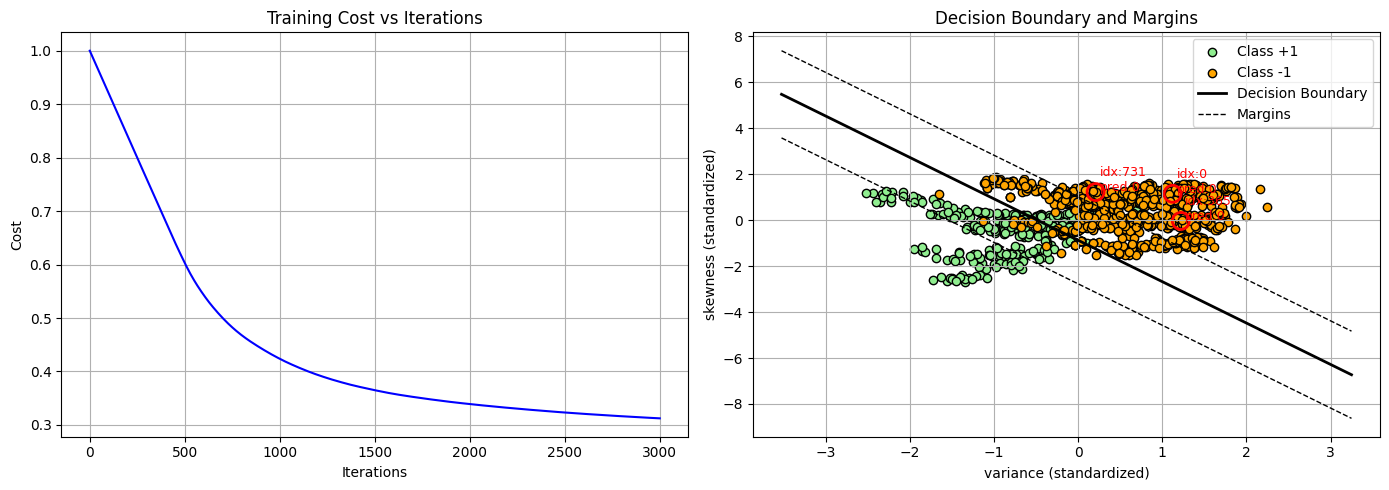

In [69]:
# Step 12: Plot Cost Curve and Decision Boundary (Subplots)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Cost vs Iterations ---
axes[0].plot(np.arange(1, len(cost_history) + 1), cost_history, color='blue')
axes[0].set_title("Training Cost vs Iterations")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("Cost")
axes[0].grid(True)

# --- Plot 2: Decision Boundary and Margins ---
ax = axes[1]
pos_idx = y_train == 1
neg_idx = y_train == -1
ax.scatter(X_train[pos_idx, 0], X_train[pos_idx, 1], c='lightgreen', label='Class +1', edgecolor='k')
ax.scatter(X_train[neg_idx, 0], X_train[neg_idx, 1], c='orange', label='Class -1', edgecolor='k')

# Compute lines for decision boundary and margins
x_vals = np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 200)
if abs(w[1]) > 1e-8:
    y_vals = -(w[0] * x_vals + b) / w[1]
    y_margin_pos = -(w[0] * x_vals + b - 1) / w[1]
    y_margin_neg = -(w[0] * x_vals + b + 1) / w[1]
    ax.plot(x_vals, y_vals, 'k-', linewidth=2, label='Decision Boundary')
    ax.plot(x_vals, y_margin_pos, 'k--', linewidth=1, label='Margins')
    ax.plot(x_vals, y_margin_neg, 'k--', linewidth=1)
else:
    ax.axvline(x=-b/w[0], color='k', linewidth=2, label='Decision Boundary')

# Mark 3 example predictions
example_indices = [0, len(X_train)//3, 2*len(X_train)//3]
for i in example_indices:
    ex = X_train[i]
    pred = np.sign(ex.dot(w) + b)
    ax.scatter(ex[0], ex[1], s=150, facecolors='none', edgecolors='r', linewidths=2)
    ax.annotate(f"idx:{i}\npred:{int((pred+1)/2)}", (ex[0]+0.05, ex[1]+0.05), fontsize=9, color='red')

ax.set_xlabel(f"{feature_cols[0]} (standardized)")
ax.set_ylabel(f"{feature_cols[1]} (standardized)")
ax.set_title("Decision Boundary and Margins")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [70]:
# Step 13: Summary with Metrics
print("\n--- Summary ---")
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print("Confusion Matrix [[TP, FP], [FN, TN]]:\n", conf_mat)


--- Summary ---
Training Accuracy: 88.24%
Test Accuracy: 76.73%
Precision: 1.000
Recall: 0.767
F1 Score: 0.868
Confusion Matrix [[TP, FP], [FN, TN]]:
 [[211   0]
 [ 64   0]]


# Linear SVM (Train on All 4 Features, Plot in 2D)

In [71]:
# ==============================================
# Linear SVM (From Scratch)
# Train on all 4 features, visualize 2D boundary
# Allowed Libraries: NumPy, Pandas, Matplotlib
# ==============================================

# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
# Step 2: Load Dataset
csv_path = "/kaggle/input/banknote-authenticationcsv/BankNote_Authentication.csv"   
df = pd.read_csv(csv_path)

In [73]:
# Step 3: Select features (all 4 for training)
feature_cols_all = ['variance', 'skewness', 'curtosis', 'entropy']
label_col = 'class'
X_all = df[feature_cols_all].values.astype(np.float64)
y = df[label_col].values.astype(np.int64)
y = np.where(y == 0, -1, 1)

In [74]:
# Step 4: Standardize all features
X_mean = X_all.mean(axis=0)
X_std = X_all.std(axis=0)
X_std[X_std == 0] = 1.0
X_scaled_all = (X_all - X_mean) / X_std

In [75]:
# Step 5: Split into Training and Test Sets
split_ratio = 0.8
split_index = int(split_ratio * len(X_scaled_all))

X_train_all = X_scaled_all[:split_index]
y_train = y[:split_index]
X_test_all = X_scaled_all[split_index:]
y_test = y[split_index:]

print(f"Training samples: {len(X_train_all)}, Test samples: {len(X_test_all)}")

Training samples: 1097, Test samples: 275


In [76]:
# Step 6: Define Hyperparameters
learning_rate = 0.01
lambda_reg = 0.01
num_iters = 2000
print_every = 200

# Step 7: Cost Function (Hinge Loss + L2 Regularization)
def hinge_loss_and_cost(w, b, X, y, lambda_reg):
    n = X.shape[0]
    scores = X.dot(w) + b
    margins = 1 - y * scores
    hinge_losses = np.maximum(0, margins)
    cost = 0.5 * lambda_reg * np.dot(w, w) + np.mean(hinge_losses)
    return cost, hinge_losses

In [77]:
# Step 8: Gradient Computation
def compute_gradients(w, b, X, y, lambda_reg):
    n = X.shape[0]
    scores = X.dot(w) + b
    mask = (y * scores) < 1
    if mask.any():
        grad_w = lambda_reg * w - (1.0 / n) * np.dot(X[mask].T, y[mask])
        grad_b = - (1.0 / n) * np.sum(y[mask])
    else:
        grad_w = lambda_reg * w
        grad_b = 0.0
    return grad_w, grad_b

In [78]:
# Step 9: Training Function (Batch Gradient Descent)
def train_linear_svm(X, y, learning_rate, lambda_reg, num_iters):
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0
    cost_history = []

    for it in range(1, num_iters + 1):
        cost, _ = hinge_loss_and_cost(w, b, X, y, lambda_reg)
        grad_w, grad_b = compute_gradients(w, b, X, y, lambda_reg)
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b
        cost_history.append(cost)

        if it % print_every == 0:
            print(f"Iteration {it}/{num_iters}, Cost = {cost:.5f}")

    return w, b, np.array(cost_history)

In [79]:
# Step 10: Train Model on All Features
w, b, cost_history = train_linear_svm(X_train_all, y_train,
                                      learning_rate, lambda_reg, num_iters)
print("Training Complete.")
print("Weights:", w)
print("Bias:", b)

Iteration 200/2000, Cost = 0.32470
Iteration 400/2000, Cost = 0.21518
Iteration 600/2000, Cost = 0.16669
Iteration 800/2000, Cost = 0.14355
Iteration 1000/2000, Cost = 0.13118
Iteration 1200/2000, Cost = 0.12388
Iteration 1400/2000, Cost = 0.11836
Iteration 1600/2000, Cost = 0.11477
Iteration 1800/2000, Cost = 0.11216
Iteration 2000/2000, Cost = 0.11034
Training Complete.
Weights: [-1.455501   -1.28166571 -1.20752205  0.19723429]
Bias: -0.35651777575204835


In [80]:
# Step 11: Predictions
def predict(X, w, b):
    scores = X.dot(w) + b
    return np.sign(scores)

y_train_pred = predict(X_train_all, w, b)
y_test_pred = predict(X_test_all, w, b)

train_accuracy = np.mean(y_train_pred == y_train) * 100
test_accuracy = np.mean(y_test_pred == y_test) * 100

print(f"\nTraining Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Training Accuracy: 97.63%
Test Accuracy: 99.27%


In [81]:
# Step 12: Compute Confusion Matrix, Precision, Recall, F1 (NumPy only)
def compute_metrics(y_true, y_pred):
    # Convert {-1, +1} → {0, 1}
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)

    TP = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
    TN = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
    FP = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
    FN = np.sum((y_true_bin == 1) & (y_pred_bin == 0))

    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    f1_score = 2 * precision * recall / (precision + recall + 1e-12)

    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])

    return precision, recall, f1_score, confusion_matrix

precision, recall, f1, conf_mat = compute_metrics(y_test, y_test_pred)

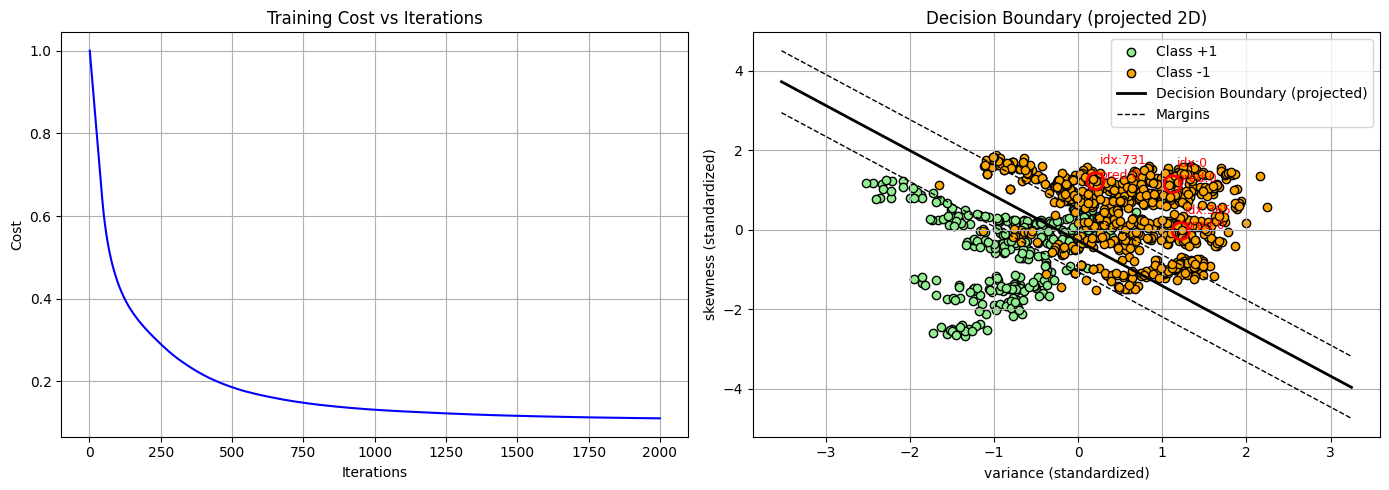

In [82]:
# Step 13: Visualization (using only 2 features for plotting)
# We'll use variance (col 0) and skewness (col 1) for display
feature_cols_plot = ['variance', 'skewness']
X_plot = X_scaled_all[:, :2]  # first two features only for plot
X_train_plot = X_plot[:split_index]
pos_idx = y_train == 1
neg_idx = y_train == -1

# Subplots: cost curve + decision boundary
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Cost vs Iterations ---
axes[0].plot(np.arange(1, len(cost_history) + 1), cost_history, color='blue')
axes[0].set_title("Training Cost vs Iterations")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("Cost")
axes[0].grid(True)

# --- Plot 2: Decision Boundary (2D projection) ---
ax = axes[1]
ax.scatter(X_train_plot[pos_idx, 0], X_train_plot[pos_idx, 1],
           c='lightgreen', label='Class +1', edgecolor='k')
ax.scatter(X_train_plot[neg_idx, 0], X_train_plot[neg_idx, 1],
           c='orange', label='Class -1', edgecolor='k')

# Project 4D weights to 2D for visualization (just first 2 components)
w_2d = w[:2]

# Compute boundary lines (approximation)
x_vals = np.linspace(X_train_plot[:, 0].min() - 1, X_train_plot[:, 0].max() + 1, 200)
if abs(w_2d[1]) > 1e-8:
    y_vals = -(w_2d[0] * x_vals + b) / w_2d[1]
    y_margin_pos = -(w_2d[0] * x_vals + b - 1) / w_2d[1]
    y_margin_neg = -(w_2d[0] * x_vals + b + 1) / w_2d[1]
    ax.plot(x_vals, y_vals, 'k-', linewidth=2, label='Decision Boundary (projected)')
    ax.plot(x_vals, y_margin_pos, 'k--', linewidth=1, label='Margins')
    ax.plot(x_vals, y_margin_neg, 'k--', linewidth=1)
else:
    ax.axvline(x=-b/w_2d[0], color='k', linewidth=2, label='Boundary')

# Mark 3 example predictions
example_indices = [0, len(X_train_plot)//3, 2*len(X_train_plot)//3]
for i in example_indices:
    ex = X_train_plot[i]
    pred = np.sign(ex.dot(w_2d) + b)
    ax.scatter(ex[0], ex[1], s=150, facecolors='none', edgecolors='r', linewidths=2)
    ax.annotate(f"idx:{i}\npred:{int((pred+1)/2)}", (ex[0]+0.05, ex[1]+0.05), fontsize=9, color='red')

ax.set_xlabel("variance (standardized)")
ax.set_ylabel("skewness (standardized)")
ax.set_title("Decision Boundary (projected 2D)")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [83]:
# Step 14: Summary with Metrics
print("\n--- Summary ---")
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print("Confusion Matrix [[TP, FP], [FN, TN]]:\n", conf_mat)


--- Summary ---
Training Accuracy: 97.63%
Test Accuracy: 99.27%
Precision: 1.000
Recall: 0.993
F1 Score: 0.996
Confusion Matrix [[TP, FP], [FN, TN]]:
 [[273   0]
 [  2   0]]
